# Part-1: Mô tả - tiền xử lý dữ liệu


Họ tên: Nguyễn Phú Trung Anh

MSSV: 18120276

- Tập dữ liệu stopwords: sử dụng theo gợi ý trong PDF.
- Tool tokenizer: sử dụng VnCoreNLP theo gợi ý trong PDF.

# Part-2: EDA - Mô hình học máy LSTM
Họ tên: Phạm Tuấn Anh
MSSV: 18120279

- EDA
- Sử dụng mô hình học máy LSTM phổ biến trong NLP.

# Part-3: Mô hình học máy Logistic Regression - Deploy
Họ tên: Đinh Nguyên Khánh
MSSV: 19120087

- Sử dụng mô hình học máy Logistic Regression
- Code app streamlit.py

### Link deploy: https://share.streamlit.io/beiryu/fake_new/main/fake_new_detection.py

---

## Import

In [205]:
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.models import Sequential, Model
from keras.preprocessing import sequence
from keras.layers import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from wordcloud import WordCloud
import re
import numpy as np
import matplotlib.pyplot as plt
import unicodedata as ud
import pandas as pd
from vncorenlp import VnCoreNLP
annotator = VnCoreNLP(address="http://127.0.0.1", port=9000)


# pd.set_option('display.max_colwidth', None)

---

## Mô tả dữ liệu
### Xem dữ liệu

In [206]:
data_df = pd.read_csv('vn_news_223_tdlfr.csv')
data_df.head()

,text,domain,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1


### Đếm số lượng dòng dữ liệu

In [207]:
data_df.shape[0]

223

### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

- Khi quan sát dữ liệu, ta thấy mỗi dòng gồm thông tin về một tin tức (cột text), domain name của trang đăng tin tức (cột domain) và chỉ số 1(giả) hay 0(thật) về tính chính xác của tin tức đó.
- Không có vấn đề gì về việc các dòng có ý nghĩa khác nhau.
- Trong tin tức có thể có nhiều câu hoặc các kí tự đặc biệt hoặc các đường link.

### Dữ liệu có các dòng bị lặp không?

In [208]:
data_df.index.duplicated().sum()

0

### Kiểm tra kiểu của dữ liệu

In [209]:
data_df.dtypes

text      object
domain    object
label      int64
dtype: object

### Kiểm tra xem có cột nào có giá trị thiếu không


In [210]:
data_df.isna().sum()

text      0
domain    0
label     0
dtype: int64

## Thiết kế các hàm tiền xử lý
### Chuẩn hoá bảng mã Unicode
Ta sẽ viết hàm chuyển sang sử dụng bộ Unicode dựng sẵn. 

In [211]:
def NFC_normalize(text):
    return ud.normalize('NFC',text)

### Loại bỏ kí tự đặc biệt
- Đầu tiên, ta thay thế các dấu xuống dòng và các dấu kết thúc câu (dấu ?, dấu !, dấu ;) bằng dấu chấm và 1 khoảng trắng. 
- Các kí tự có thể chỉ ngày tháng, tỉ số như '/' hay '-' sẽ được giữ nguyên.
- Các kí tự đặc biệt còn lại ngoài dấu chấm sẽ được thay bằng khoảng trắng.

In [212]:
special_char = '@#$^&*()[]{}:,<>\|`~=_+-'


def remove_noice(text):
    result = ""
    for c in text:
        if ((c == '\n') or (c == '?') or (c == '!') or (c == ';')):
            result += '. '
        else:
            i = special_char.find(c)
            if (i != -1):
                result += ' '
            else:
                result += c
    return result

Sau khi đã tách token đúng, ta thực hiện xóa các dấu chấm '.', '..' hoặc '...' ở cuối câu trong list vừa thu được. 

In [213]:
def remove_dot(list):
    for sentence in list[:]:
        for word in sentence:
            word = word.replace('.', '')
    return list

### Lowercase các token
Ta thực hiện lowercase sau khi đã tách token. Sở dĩ không lowercase trước khi tách token là để tool tách token tách được tên riêng đúng.

In [214]:
def lower_case(list):
    for sentence in list:
        for i in range(len(sentence)):
            sentence[i] = sentence[i].lower()
    return list

### Loại bỏ stop word
Ta đọc vào các stopword từ file vietnamese-stopwords.txt. Tiếp đó sẽ xây dựng 1 list gồm các stopwords có cấu trúc giống 1 token khi tách các tin tức (để dễ so sánh).

In [215]:
stopwords = []
f = open('vietnamese-stopwords.txt', encoding="utf8")
lines = f.readlines()
for l in lines:
    # xóa kí tự xuống dòng
    l = l.rstrip("\n")
    # chuẩn hóa
    l = NFC_normalize(l)
    # tạo token stopword
    string = ""
    for c in l:
        if (c != ' '):
            string += c
        else:
            string += '_'
    stopwords.append(string)
# xem list stopwords:
stopwords

['a_lô',
 'a_ha',
 'ai',
 'ai_ai',
 'ai_nấy',
 'ai_đó',
 'alô',
 'amen',
 'anh',
 'anh_ấy',
 'ba',
 'ba_ba',
 'ba_bản',
 'ba_cùng',
 'ba_họ',
 'ba_ngày',
 'ba_ngôi',
 'ba_tăng',
 'bao_giờ',
 'bao_lâu',
 'bao_nhiêu',
 'bao_nả',
 'bay_biến',
 'biết',
 'biết_bao',
 'biết_bao_nhiêu',
 'biết_chắc',
 'biết_chừng_nào',
 'biết_mình',
 'biết_mấy',
 'biết_thế',
 'biết_trước',
 'biết_việc',
 'biết_đâu',
 'biết_đâu_chừng',
 'biết_đâu_đấy',
 'biết_được',
 'buổi',
 'buổi_làm',
 'buổi_mới',
 'buổi_ngày',
 'buổi_sớm',
 'bà',
 'bà_ấy',
 'bài',
 'bài_bác',
 'bài_bỏ',
 'bài_cái',
 'bác',
 'bán',
 'bán_cấp',
 'bán_dạ',
 'bán_thế',
 'bây_bẩy',
 'bây_chừ',
 'bây_giờ',
 'bây_nhiêu',
 'bèn',
 'béng',
 'bên',
 'bên_bị',
 'bên_có',
 'bên_cạnh',
 'bông',
 'bước',
 'bước_khỏi',
 'bước_tới',
 'bước_đi',
 'bạn',
 'bản',
 'bản_bộ',
 'bản_riêng',
 'bản_thân',
 'bản_ý',
 'bất_chợt',
 'bất_cứ',
 'bất_giác',
 'bất_kì',
 'bất_kể',
 'bất_kỳ',
 'bất_luận',
 'bất_ngờ',
 'bất_nhược',
 'bất_quá',
 'bất_quá_chỉ',
 'bất_thình_l

Kiểm tra xem có đủ lượng stopword so với trong file txt không (1942 dòng)

In [216]:
assert (len(stopwords)==1942)

Sau đó ta viết hàm loại bỏ những token là stopword ra khỏi list token đã tách ở trước:

In [217]:
def remove_stopwords(row, stopwords):
    for sentence in row[:]:
        for token in sentence[:]:
            if (token in stopwords):
                sentence.remove(token)
    return row

In [218]:
def http_remove(txt):
    return re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', '', txt)

---

In [219]:
# test thử với 1 chuỗi text bất kì
text = 'Phiên bản 3.5... Các "nhân sự" Jupyter? Bạn cần gì\ vào 3/5? Bao giờ~ trở về? Bất kể là đúng đi chăng nữa! Biết đâu chừng https://giadinhvietnam.com/xot-xa-hinh-anh-thay-tro-loi-bun-bang-rung-den-truong-o-nghe-an-d132732.html'
print("Before processing: ")
print(text)
text = http_remove(text)
text = NFC_normalize(text)
text = remove_noice(text)
text = annotator.tokenize(text)
text = remove_dot(text)
text = lower_case(text)
text = remove_stopwords(text, stopwords)
print("After processing:")
print(text)

Before processing: 
Phiên bản 3.5... Các "nhân sự" Jupyter? Bạn cần gì\ vào 3/5? Bao giờ~ trở về? Bất kể là đúng đi chăng nữa! Biết đâu chừng https://giadinhvietnam.com/xot-xa-hinh-anh-thay-tro-loi-bun-bang-rung-den-truong-o-nghe-an-d132732.html
After processing:
[['phiên_bản', '3.5', '...'], ['"', 'nhân_sự', '"', 'jupyter', '.'], ['3/5', '.'], ['trở', '.'], ['đi_chăng_nữa', '.'], []]


---

## Thực hiện tất cả các bước tiền xử lý

In [220]:
def pre_process(row):
    # lấy ra text
    text = row['text']
    # Loại bỏ link:
    text = http_remove(text)
    # chuẩn hóa unicode dựng sẵn
    text = NFC_normalize(text)
    # loại bỏ kí tự đặc biệt lần 1
    text = remove_noice(text)
    # tách token (thực hiện tách token sau bước loại noice lần 1 để tách đúng token)
    text = annotator.tokenize(text)
    # loại bỏ token . cuối câu vì không còn tác dụng
    text = remove_dot(text)
    # lowercase
    text = lower_case(text)
    # loại bỏ stopwords
    text = remove_stopwords(text, stopwords)
    # loại bỏ array trống
    text = [x for x in text if x != []]

    return text

In [221]:
#sử dụng hàm pre-process vào dataframe
data_df['tokens'] = data_df.apply(pre_process,axis=1)

In [222]:
def clean_joined(x):
    bag = []
    for line in x:
        for word in line:
            if (word not in bag) and (word.isdigit() == False):
                bag.append(word)
            else:
                continue
    return bag

In [223]:
data_df['clean_tokens'] = data_df['tokens'].apply(clean_joined)

In [224]:
# số lượng token lớn nhất là?
max_tokens = data_df['clean_tokens'].max()
len(max_tokens)

104

In [225]:
data_df

,text,domain,label,tokens,clean_tokens
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1,"[[thủ_tướng, abe, cúi, đầu, xin_lỗi, hành_động...","[thủ_tướng, abe, cúi, đầu, xin_lỗi, hành_động,..."
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1,"[[thủ_tướng, nhật, cúi, đầu, xin_lỗi, tinh_thầ...","[thủ_tướng, nhật, cúi, đầu, xin_lỗi, tinh_thần..."
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1,"[[choáng, .], [cơ_trưởng, đeo, khăn_quàng, quẩ...","[choáng, ., cơ_trưởng, đeo, khăn_quàng, quẩy, ..."
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1,"[[nhạc, kpop, hát, .], [.], [.], [.], [giáo_sư...","[nhạc, kpop, hát, ., giáo_sư, nguyễn_lân_dũng,..."
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1,"[[đại_học, hutech, áp_dụng, cải_cách, "", tiếq_...","[đại_học, hutech, áp_dụng, cải_cách, "", tiếq_v..."
...,...,...,...,...,...
218,“Siêu máy bay” A350 sẽ chở CĐV Việt Nam đi Mal...,dantri.com.vn,0,"[[“, siêu, máy_bay, ”, a350, chở, cđv, việt_na...","[“, siêu, máy_bay, ”, a350, chở, cđv, việt_nam..."
219,Thưởng 20.000 USD cho đội tuyển cờ vua Việt Na...,dantri.com.vn,0,"[[thưởng, 20.000, usd, đội_tuyển, cờ_vua, việt...","[thưởng, 20.000, usd, đội_tuyển, cờ_vua, việt_..."
220,Trường Sơn giành HCV tại giải cờ vua đồng đội ...,dantri.com.vn,0,"[[trường_sơn, giành, hcv, giải, cờ_vua, đồng_đ...","[trường_sơn, giành, hcv, giải, cờ_vua, đồng_độ..."
221,Chuyện về chàng sinh viên Luật - Kiện tướng Lê...,dantri.com.vn,0,"[[chàng, sinh_viên, luật, kiện_tướng, lê_tuấn_...","[chàng, sinh_viên, luật, kiện_tướng, lê_tuấn_m..."


Sau khi tiền xử lý, trong dataframe có thêm 1 cột tokens.
- Miêu tả cột tokens:
[ [các token của câu văn 1], [các token của câu văn 2], [các token của câu văn 3],...]

---

# Part 2: EDA và học máy

## Khám phá dữ liệu.

### cột label kết quả

In [226]:
# thống kê các cột
data_df['word_count'] = data_df['text'].apply(lambda x: len(x.split()))

In [227]:
list_of_words = []
for i in data_df['clean_tokens']:
    list_of_words.append(i)

In [228]:
list_of_words

[['thủ_tướng',
  'abe',
  'cúi',
  'đầu',
  'xin_lỗi',
  'hành_động',
  'phi',
  'thể_thao',
  'tuyển',
  'nhật',
  '.',
  'sankei_sports',
  'nhật_bản',
  'shinzo_abe',
  'công_khai',
  'gửi',
  'hoàng',
  'toàn_bộ',
  'người_dân',
  'tinh_thần',
  'thi_đấu',
  'đội_tuyển',
  'world_cup',
  '..',
  'tối_qua',
  'lượt',
  'trận',
  'vòng',
  'bảng',
  'chỉ_số',
  'phụ',
  'senegal',
  'đội',
  'thua',
  'colombia',
  'fair',
  'play',
  'thẻ',
  'phạt',
  '“',
  'võ_sĩ_đạo',
  'samurai',
  'thượng_võ',
  'chỉ_trích',
  'bất_bình',
  'toàn',
  'dân',
  'hình_ảnh',
  'kiên_cường',
  'đấu_trường',
  'quốc_tế',
  'đứng',
  'thành_thật',
  'trách_nhiệm',
  'sâu_sắc',
  'nhân_dân',
  '”',
  'nổi_tiếng',
  'chất',
  'áo',
  'xanh',
  'mệnh_danh',
  'dữ_dội',
  'hâm_mộ',
  'bóng_đá',
  'lối',
  'bóng',
  'tiêu_cực',
  'cố_tình',
  'câu',
  'để_dành',
  'vé',
  'đi',
  'tiếp',
  'phút',
  'ba_lan',
  'thắng',
  'tỷ_số',
  'tỉ_số',
  'tương_tự',
  'cầu_thủ',
  'hề',
  'gỡ',
  'hoà',
  'vui_vẻ',


In [229]:
# số lượng từ độc nhất(unique)
total_words = []
for line in list_of_words:
    for word in line:
        if word not in total_words:
            total_words.append(word)
        else:
            continue

In [230]:
total_words

['thủ_tướng',
 'abe',
 'cúi',
 'đầu',
 'xin_lỗi',
 'hành_động',
 'phi',
 'thể_thao',
 'tuyển',
 'nhật',
 '.',
 'sankei_sports',
 'nhật_bản',
 'shinzo_abe',
 'công_khai',
 'gửi',
 'hoàng',
 'toàn_bộ',
 'người_dân',
 'tinh_thần',
 'thi_đấu',
 'đội_tuyển',
 'world_cup',
 '..',
 'tối_qua',
 'lượt',
 'trận',
 'vòng',
 'bảng',
 'chỉ_số',
 'phụ',
 'senegal',
 'đội',
 'thua',
 'colombia',
 'fair',
 'play',
 'thẻ',
 'phạt',
 '“',
 'võ_sĩ_đạo',
 'samurai',
 'thượng_võ',
 'chỉ_trích',
 'bất_bình',
 'toàn',
 'dân',
 'hình_ảnh',
 'kiên_cường',
 'đấu_trường',
 'quốc_tế',
 'đứng',
 'thành_thật',
 'trách_nhiệm',
 'sâu_sắc',
 'nhân_dân',
 '”',
 'nổi_tiếng',
 'chất',
 'áo',
 'xanh',
 'mệnh_danh',
 'dữ_dội',
 'hâm_mộ',
 'bóng_đá',
 'lối',
 'bóng',
 'tiêu_cực',
 'cố_tình',
 'câu',
 'để_dành',
 'vé',
 'đi',
 'tiếp',
 'phút',
 'ba_lan',
 'thắng',
 'tỷ_số',
 'tỉ_số',
 'tương_tự',
 'cầu_thủ',
 'hề',
 'gỡ',
 'hoà',
 'vui_vẻ',
 'fifa',
 'quy_định',
 'thẻ_vàng',
 'thành',
 'thẻ_đỏ',
 'sợ',
 'lãnh',
 'giết',
 'ch

In [231]:
len(total_words)

8486

In [232]:
data_df['clean_joined'] = data_df['clean_tokens'].apply(lambda x: " ".join(x))

In [233]:
data_df['clean_joined']

0      thủ_tướng abe cúi đầu xin_lỗi hành_động phi th...
1      thủ_tướng nhật cúi đầu xin_lỗi tinh_thần phi t...
2      choáng . cơ_trưởng đeo khăn_quàng quẩy banh sâ...
3      nhạc kpop hát . giáo_sư nguyễn_lân_dũng ‘ thàn...
4      đại_học hutech áp_dụng cải_cách " tiếq_việt nă...
                             ...                        
218    “ siêu máy_bay ” a350 chở cđv việt_nam đi mala...
219    thưởng 20.000 usd đội_tuyển cờ_vua việt_nam ol...
220    trường_sơn giành hcv giải cờ_vua đồng_đội thế_...
221    chàng sinh_viên luật kiện_tướng lê_tuấn_minh ....
222    tiền_đạo malaysia “ hàng thủ đội_tuyển việt_na...
Name: clean_joined, Length: 223, dtype: object

### Các token phổ biến

In [234]:
# Trung bình mỗi text có bao nhiêu từ?
data_df['word_count'].mean()

564.713004484305

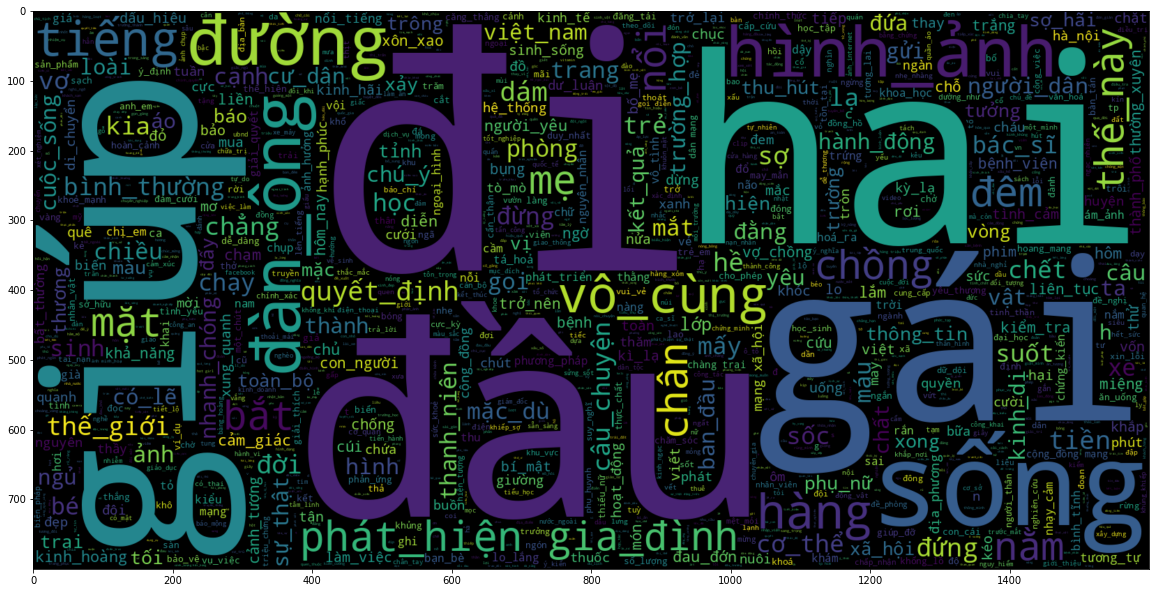

In [235]:
# token thuộc label 1
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(
    " ".join(data_df[data_df.label == 1].clean_joined))
plt.imshow(wc, interpolation='bilinear')

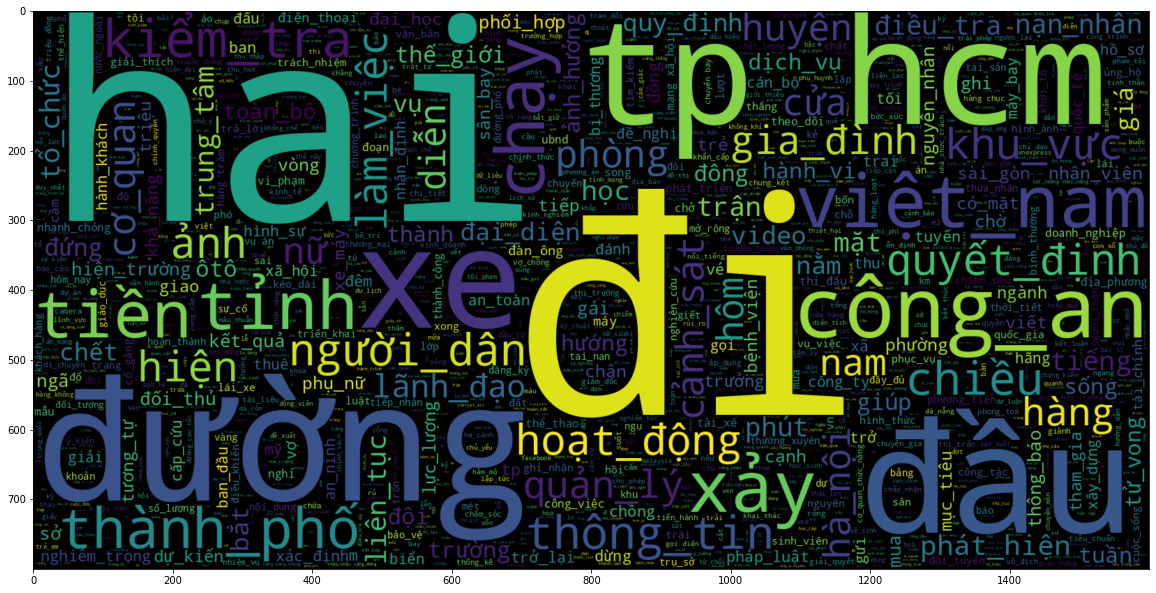

In [236]:
# token thuộc label 0
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(
    " ".join(data_df[data_df.label == 0].clean_joined))
plt.imshow(wc, interpolation='bilinear')

In [237]:
#  Text có nhiều từ nhất gồm bao nhiêu từ?
data_df['word_count'].max()

2331

In [238]:
# Cột output có bao nhiêu giá trị thiếu?
data_df['label'].isna().sum()

0

0    55.156951
1    44.843049
Name: label, dtype: float64

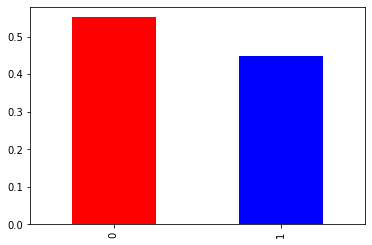

In [239]:
# Tỉ lệ các lớp trong cột output?
data_df['label'].value_counts(normalize=True).plot(
    kind="bar", color=["red", "blue"])
data_df['label'].value_counts(normalize=True) * 100

Tỉ lệ giữa các lớp cũng khá cân bằng, 

### Tách dữ liệu

In [240]:
# Tách X và y
y_sr = data_df['label']
X_df = data_df['clean_joined']

In [241]:
y_sr

0      1
1      1
2      1
3      1
4      1
      ..
218    0
219    0
220    0
221    0
222    0
Name: label, Length: 223, dtype: int64

In [242]:
# Tách tập huấn luyện và tập validation theo tỉ lệ 80%:20%
X_train, X_val, y_train, y_val = \
    train_test_split(X_df, y_sr,
                     test_size=0.2)

In [243]:
X_train

109    mưa bão usagi ngập_úng ha rau lâm_đồng . 27/11...
96     giây dừng chờ đèn_đỏ đàn_ông quốc_gia khóc thé...
87     xăm “ chỗ_kín ” thiếu_nữ tái mặt điều_kinh dị ...
191    nghi phạm sát_hại gia_đình tiền_giang bắt . tr...
55     phát hoảng tiếng rít đinh_tai đêm chạy kêu cứu...
                             ...                        
202    mua vé trận chung_kết chen_lấn giẫm_đạp hỗn_lo...
188    đi học mẹ thái_lan bắt nhặt rác . asia_one 22/...
6      thẳng_thắn vụ_việc usd cải_cách giáo_dục “ sân...
5      cười_vỡ_bụng tiếng cải_cách " vuông_tròn xâm_n...
81     thò vườn đừng chạm chạy . đời câu_chuyện kỳ_lạ...
Name: clean_joined, Length: 178, dtype: object

In [244]:
X_val.shape

(45,)

In [245]:
y_train.shape

(178,)

In [246]:
y_val.shape

(45,)

### Tokenizer & padding

In [247]:
tokenizer = Tokenizer(num_words=len(total_words))
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_val)

In [248]:
padded_train = pad_sequences(train_sequences, maxlen=len(
    max_tokens), padding='post', truncating='post')
padded_test = pad_sequences(
    test_sequences, maxlen=len(max_tokens), truncating='post')

### Chuẩn bị model


In [249]:
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(len(total_words), output_dim=128))
# model.add(Embedding(total_words, output_dim = 240))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         1086208   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,382,401
Trainable params: 1,382,401
Non-trainable params: 0
_________________________________________________________________


In [250]:
model.fit(padded_train, y_train, batch_size=64,
          validation_split=0.1, epochs=25)

Epoch 1/25
3/3 [==============================] - 4s 455ms/step - loss: 0.6920 - acc: 0.5375 - val_loss: 0.6838 - val_acc: 0.6111
Epoch 2/25
3/3 [==============================] - 0s 122ms/step - loss: 0.6776 - acc: 0.6062 - val_loss: 0.6676 - val_acc: 0.6111
Epoch 3/25
3/3 [==============================] - 0s 122ms/step - loss: 0.6498 - acc: 0.7625 - val_loss: 0.6327 - val_acc: 0.7222
Epoch 4/25
3/3 [==============================] - 0s 124ms/step - loss: 0.5760 - acc: 0.9250 - val_loss: 0.5060 - val_acc: 0.7222
Epoch 5/25
3/3 [==============================] - 0s 123ms/step - loss: 0.3313 - acc: 0.9062 - val_loss: 0.2073 - val_acc: 0.9444
Epoch 6/25
3/3 [==============================] - 0s 124ms/step - loss: 0.0989 - acc: 0.9563 - val_loss: 0.2730 - val_acc: 0.9444
Epoch 7/25
3/3 [==============================] - 0s 173ms/step - loss: 0.0327 - acc: 0.9875 - val_loss: 0.2904 - val_acc: 0.9444
Epoch 8/25
3/3 [==============================] - 0s 133ms/step - loss: 0.0019 - acc: 1.00

In [251]:
# make prediction
pred = model.predict(padded_test)

In [252]:
# if the predicted value is >0.5 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [253]:
# getting the accuracy

accuracy = accuracy_score(list(y_val), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9111111111111111


In [254]:
result = model.evaluate(padded_test, np.asarray(y_val))
print("Accuracy : {}".format(result[1]))

2/2 [==============================] - 1s 18ms/step - loss: 0.9114 - acc: 0.9111
Accuracy : 0.9111111164093018


<AxesSubplot:>

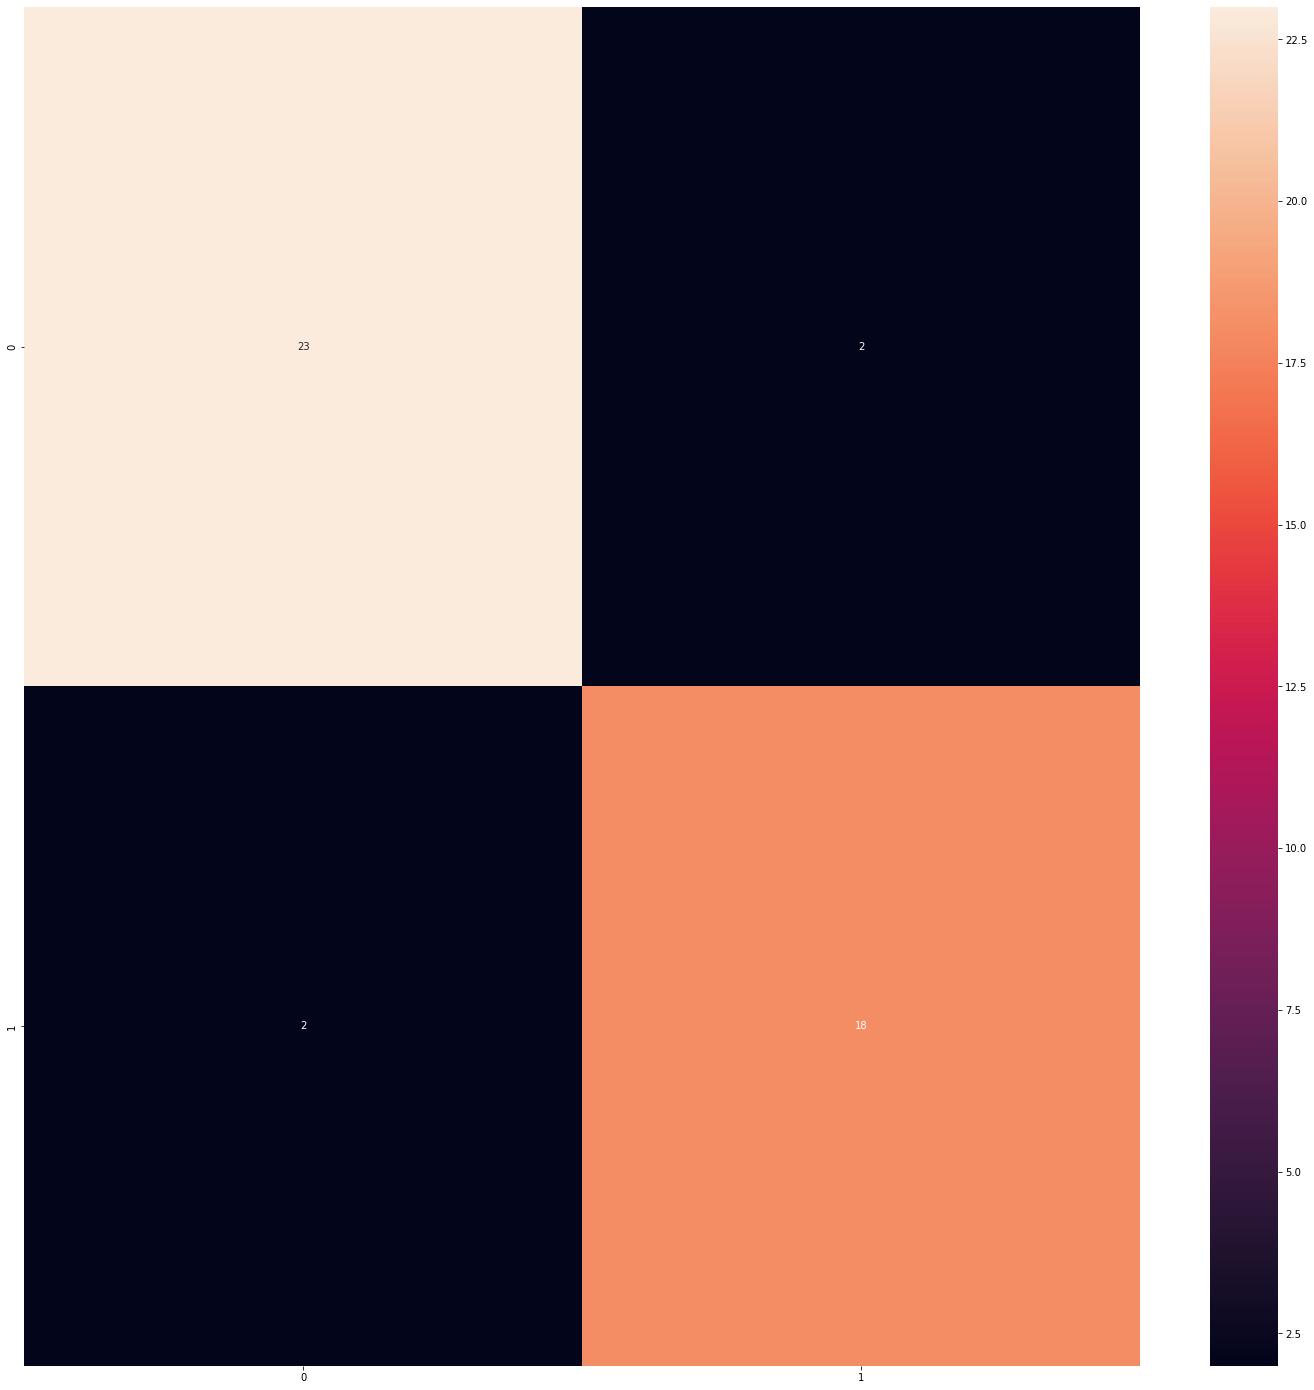

In [255]:
# get the confusion matrix
cm = confusion_matrix(list(y_val), prediction)
plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True)

In [256]:
# Check version for save the model
print(tf.__version__)

2.7.0


In [257]:
model.save_weights('./model/lstm_model/')

# Part 3: Logistic Regression - Deploy

In [258]:
# Tách tập huấn luyện và tập validation theo tỉ lệ 7:3
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_sr, test_size=0.3, stratify=y_sr, random_state=100)

In [259]:
X_train.head()

188    đi học mẹ thái_lan bắt nhặt rác . asia_one 22/...
7      hại não vọng_cổ vuông_tròn tam_giác . chương_t...
219    thưởng 20.000 usd đội_tuyển cờ_vua việt_nam ol...
189    ôtô đi ngược chiều phạt 800.000 đồng . khoản l...
23     bi_kịch ngoại_tình bố chồng . thành “ đàn_bà ”...
Name: clean_joined, dtype: object

In [260]:
tfidf = TfidfVectorizer(ngram_range=(1, 3), lowercase=True, max_features=5000)
X_train_transformed = tfidf.fit_transform(X_train)
X_test_transformed = tfidf.transform(X_test)

In [261]:
X_train_transformed.shape

(156, 5000)

In [262]:
lr = LogisticRegression()
lr.fit(X_train_transformed, y_train)

LogisticRegression()

In [263]:
y_pred = lr.predict(X_test_transformed)

In [264]:
# Get accuracy
result = accuracy_score(y_test, y_pred)
print("Accuracy : {}".format(result))

Accuracy : 0.8656716417910447


<AxesSubplot:>

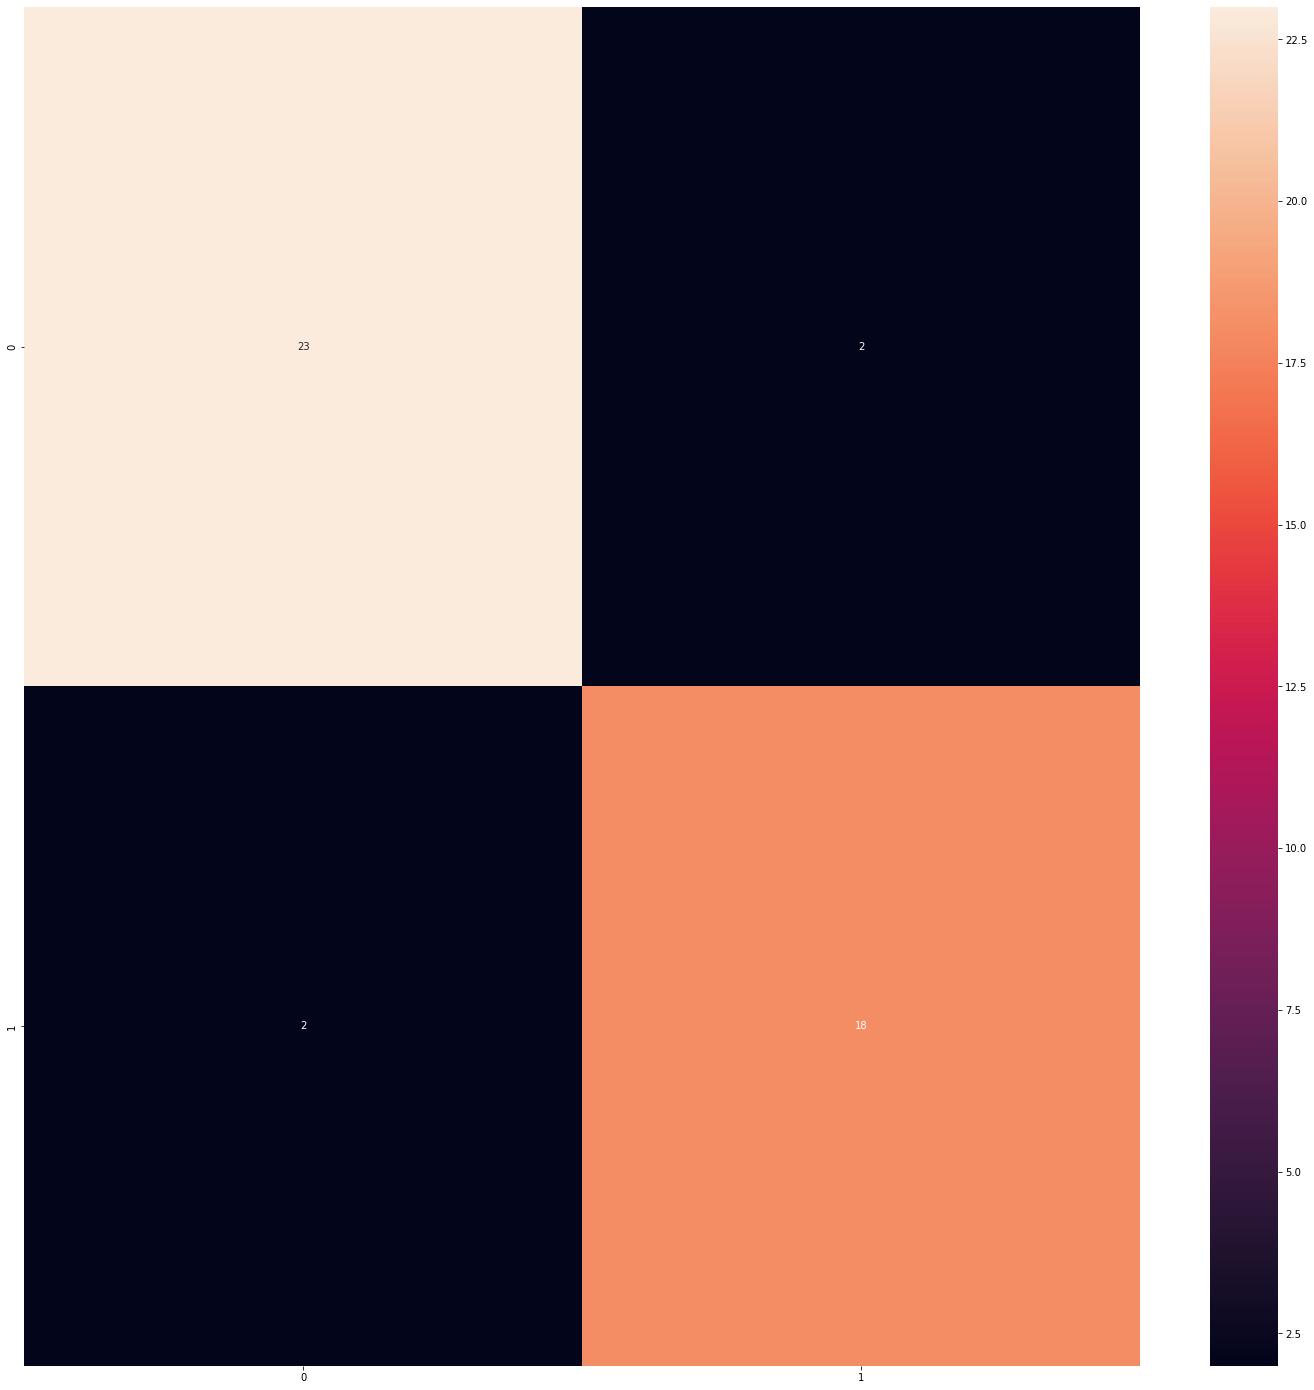

In [265]:
# get the confusion matrix
confusion_matrix(y_test, y_pred)
plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True)

In [266]:
# save model
with open('./model/lr_model.pkl', 'wb') as f:
    pickle.dump(lr, f)